# Logistic Regression Proje

Machine Learning dünyasında çok ünlü bir problem var: Titanic.

Burada amaç Titanic gemisinde yer alan hangi yolcuların hayatta kaldığını tahmin etmek.

Titanic - Machine Learning from Disaster

https://www.kaggle.com/c/titanic/overview

### 1. Kütüphaneler

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 2. Data Seti

**Önemli Not:** Kaggle yarışmalarında bazen data,
* train data
* test data
olarak ayrı verilir.

Buradaki test data bizim model oluştururken kullanacağımız test data değildir.

Bu test data Kaggle'in yarışma sonuçları test etmek için kullandığı datadır.

Dolayısı ile bu test data içinde sonuç değişkeni yani gerçek label değeri (grand truth) bulunmaz.

O yüzden biz kendi model doğruluğumuzu ölçerken o test datayı kullanamyız.

Biz yine train_test_split ile kendi test datamızı oluşturacağız.

In [2]:
# CSV data'yı bir DataFrame içine al
train_df = pd.read_csv("data/train.csv")

In [3]:
# train data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 3. Veri Kalitesi & Eksik Değerler (Missing Values)

Veri içinde her zaman eksik değerler bulunabilir.

Bu eksik değerleri yönetmenin çeşitli yolları vardır:
1. Eksik değer içeren satırları tamamen veri setinden çıkarmak
2. Eksik değerleri uygun değerler ile doldumak:
    * Mean (ortalama)
    * Median (Ortanca)

In [4]:
# train data içindeki eksik değerlere bakalım

train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### 3.1 Age - Eksik Değerler

In [5]:
# Age (yaş) için eksik değerlerin oranı

train_df['Age'].isnull().sum() / train_df.shape[0] * 100

19.865319865319865

Yolcuların yaklaşık %20'sinin yaş (Age) değerleri eksik.

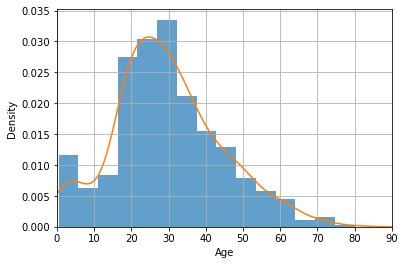

In [6]:
ax = train_df['Age'].hist(bins=15, density=True, stacked=True, alpha=0.7)

train_df['Age'].plot(kind='density')

ax.set(xlabel='Age')
plt.xlim(0, 90)
plt.grid()
plt.show()

In [7]:
# mean -> ortalama
# skipna -> eksik verileri es geç (skip)

train_df['Age'].mean(skipna=True)

29.69911764705882

In [8]:
# median -> ortanca
# skipna -> eksik verileri es geç (skip)

train_df['Age'].median(skipna=True)

28.0

#### 3.2 Cabin - Eksik Değerler

In [9]:
# Cabin için eksik değerler oranı

train_df['Cabin'].isnull().sum() / train_df.shape[0] * 100

77.10437710437711

Yolcuların %77'sinin Cabin numarası bilgisi eksik.

Burada kritik bir karar vermek gerekiyor.

Eldeki %23 ile %77'ün değerlerini mi doldurmalıyız yoksa bu sütunu tamamen çıkarmalı mıyız?

**Karar:** %77'lik bir eksik veri oranı çok yüksek olduğu için en doğrusu bu sütunu çıkarmak olacak.

#### 3.3 Embarked - Eksik Değerler

Embark -> gemiye binmek

In [10]:
# embarked (gemiye binme) için eksik değer oranı

train_df['Embarked'].isnull().sum() / train_df.shape[0] * 100

0.22446689113355783

%0.2 gibi (sadece 2 adet aslında) çok düşük bir oran o yüzden bu sütundaki eksik dataları dolduracağız.

In [11]:
# yolcuların nereden bindiklerine bakalım

print('Yolcuların hangi limandan bindikleri % olarak: (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train_df['Embarked'].value_counts() / train_df.shape[0] * 100)

Yolcuların hangi limandan bindikleri % olarak: (C = Cherbourg, Q = Queenstown, S = Southampton):
S    72.278339
C    18.855219
Q     8.641975
Name: Embarked, dtype: float64


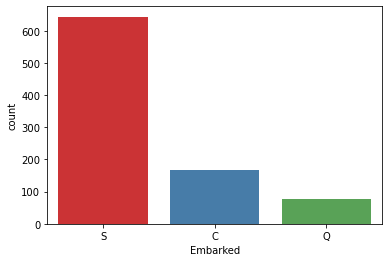

In [12]:
# grafik ile de görelim

sns.countplot(x='Embarked', data=train_df, palette='Set1')
plt.show()

Eksik değerleri ne ile dolduracağımıza karar verirken burada (Embarked) Mean, Median vs kullanamayız,

Çünkü liman bilgisi kategorik bir bilgi.

O zaman ne yapacağız?

In [13]:
# en fazla binilen limanı bulalım -> idmax()

print('En fazla binilen liman: ', train_df['Embarked'].value_counts().idxmax())

En fazla binilen liman:  S


En fazla binilen liman uzakara S olduğu için biz de eksik dataları S olarak kabul edeceğiz.

#### 3.4 Nihai Karar ve Uygulama

Eksik değer içeren sütunlar için nihai karar:
* Age -> Median yöntemi ile eksik değerleri dolduracağız (median = 28)
* Embarked -> eksik değerleri 'S' olarak dolduracağız
* Cabin -> çok fazla (%77) eksik değer olduğu için bu sütunu çıkaracağız

In [14]:
# önce orijinal verimizi kopyalayalım

train_data = train_df.copy()

In [15]:
# Age -> eksikleri median ile dolduralım -> fillna()

train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)

In [16]:
# Embarked -> eksikleri 'S' ile dolduralım

train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)

In [17]:
# Cabin -> bu sütunu çıkaralım -> drop

train_data.drop('Cabin', axis=1, inplace=True)

In [18]:
# şimdi bu ayarlamalardan sonra train_data'da eksik veri var mı bakalım

train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [19]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C


#### 3.5 Fazladan olan (Gereksiz) Değişken Analizi

Birbiri ile ilgili olan iki sütun var: SibSp, Parch

**SibSp**: # of siblings / spouses aboard the Titanic

çocuk adedi (çift, karı-koca, için)

**Parch**: # of parents / children aboard the Titanic

çocuklar için ebeveyn sayısı

Gördüğünüz gibi, iki değişken de birbiri ile çok ilgili ve aralında yüksek oranda korelasyon var.

Bu iki değişkeni tek bir değişken altında toplamak daha sağlıklı olacak: **Yanlız mı seyahat ediyor**

Değişkenimizin adı **YalnizSeyahat** olsun. Ve bu kategorik bir değişken olacak. 0 veya 1.

In [20]:
# SibSp ve Parch'a bakıp eğer ikisinin toplamı sıfır'dan büyükse o zaman yanlız seyahat etmiyordur -> 0
# diyeceğiz
# eğer toplamları sıfır ise o zaman yanlız seyahat ediyordur -> 1

train_data['YalnizSeyahat'] = np.where((train_data["SibSp"] + train_data["Parch"]) > 0, 0, 1)

In [21]:
# SibSp ve Parch sütunlarını atalım

train_data.drop('SibSp', axis=1, inplace=True)

train_data.drop('Parch', axis=1, inplace=True)

In [22]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,YalnizSeyahat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,1


#### 3.6 Kategorik Değişkenler

"Pclass","Embarked","Sex" sütunları kategorik -> onları encode etmemiz lazım

In [23]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,YalnizSeyahat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,1


In [24]:
# get_dummies() ile encode edelim

train_data = pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"], drop_first=True)

In [25]:
train_data.head()

,PassengerId,Survived,Name,Age,Ticket,Fare,YalnizSeyahat,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,1,0,"Braund, Mr. Owen Harris",22.0,A/5 21171,7.2500,0,0,1,0,1,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,71.2833,0,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,7.9250,1,0,1,0,1,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,53.1000,0,0,0,0,1,0
4,5,0,"Allen, Mr. William Henry",35.0,373450,8.0500,1,0,1,0,1,1


"PassengerId", "Name" ve "Ticket" sütunlarını atalım.

In [26]:
train_data.drop('PassengerId', axis=1, inplace=True)
train_data.drop('Name', axis=1, inplace=True)
train_data.drop('Ticket', axis=1, inplace=True)

In [27]:
train_data.head()

,Survived,Age,Fare,YalnizSeyahat,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,1,0,1,1
1,1,38.0,71.2833,0,0,0,0,0,0
2,1,26.0,7.9250,1,0,1,0,1,0
3,1,35.0,53.1000,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,1,0,1,1


### 4. Exploratory Data Analysis (EDA)

In [28]:
# train datanın şekli

train_data.shape

(891, 9)

In [29]:
# train data içindeki toplam veri adedi

print("train data içindeki toplam veri adedi:", train_data.shape[0])

train data içindeki toplam veri adedi: 891


In [30]:
# sütun adları -> train

col_names = train_data.columns

col_names

Index(['Survived', 'Age', 'Fare', 'YalnizSeyahat', 'Pclass_2', 'Pclass_3',
       'Embarked_Q', 'Embarked_S', 'Sex_male'],
      dtype='object')

#### 4.1 Age için EDA

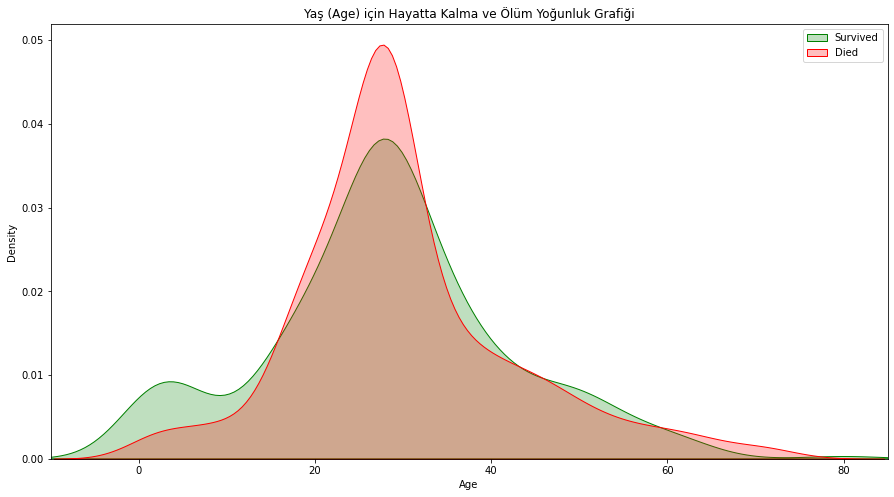

In [31]:
plt.figure(figsize=(15,8))

# Hayatta kalanlar -> Survived == 1
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html
ax = sns.kdeplot(train_data["Age"][train_data.Survived == 1], color="green", shade=True)

# Ölenler -> Survived == 0
sns.kdeplot(train_data["Age"][train_data.Survived == 0], color="red", shade=True)

plt.legend(['Survived', 'Died'])
plt.title('Yaş (Age) için Hayatta Kalma ve Ölüm Yoğunluk Grafiği')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()


Hayatta kalanların ve ölenlerin yaş dağılımları oldukça benzer.

Şunu söyleyebiliriz, hayatta kalanlar içinde çocuk ve genç yaşta olanların oranları daha fazla.

Bunun sebebi, ebevenylerin kendi hayatlarını kurtarmak yerine çocukların hayatlarını kurtarmak için onlara can yeleği ve kayık vermeleri olabilir. (sadece varsayım tabi)

#### 4.2 Fare (Ücret) için EDA

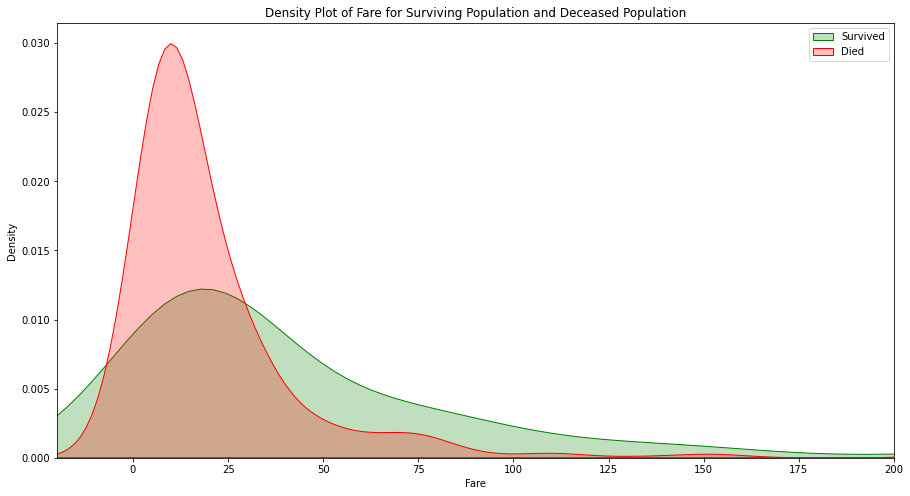

In [32]:
plt.figure(figsize=(15,8))

ax = sns.kdeplot(train_data["Fare"][train_data.Survived == 1], color="green", shade=True)

sns.kdeplot(train_data["Fare"][train_data.Survived == 0], color="red", shade=True)

plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

Ücret üzerinden baktığımızda hayatta kalma ve ölme oranlarının net olarak birbirinden ayrıldığını görüyoruz.

Ücretin bizim modelimizde önemli bir etken olma olasılığı yüksek.

Düşük ücret ödeyen yolcuların ölüm oranları çok daha yüksek.

Yüksek ücret ödeyenlerin hayatta kalma oranı daha fazla.

#### 4.3 Passanger Class (Yolcu Sınıfı) için EDA

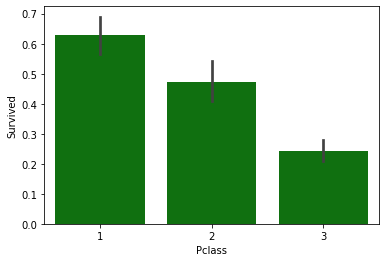

In [33]:
sns.barplot('Pclass', 'Survived', data=train_df, color="green")

plt.show()

Passenger Class'ı yani Yolcu Sınıfı 1. sınıf olan yolcuların hayatta kalma oranları daha yüksek.

Dolayısı ile bu da Ücret için yaptığımız varsayımı doğrular nitelikte.

#### 4.4 Aile ile veya Yalnız Seyahat için EDA

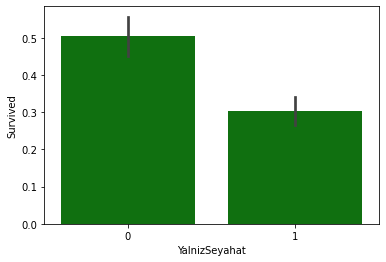

In [34]:
sns.barplot('YalnizSeyahat', 'Survived', data=train_data, color="green")

plt.show()

Aile ile seyhat edenlerin (YalnizSeyahat = 0) hayatta kalma oranları daha yüksek.

Bu da bunların çoğunun çocuk ya da genç olduğu ve onların görece daha fazla hayatta kaldıkları varsayımımızı destekliyor.

#### 4.5 Sex (Cinsiyet) için EDA

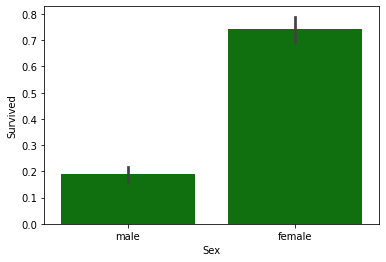

In [35]:
sns.barplot('Sex', 'Survived', data=train_df, color="green")

plt.show()

Cinsiyete baktığımızda Kadın ve Erkek'lerin hayatta kalma oranları arasında büyük bir fark görüyoruz.

Kadınların hayatta kalma oranları çok daha yüksek.

### 5. Input-Output Ayrımı

In [36]:
y = train_data['Survived']

In [37]:
train_data.drop('Survived', axis=1, inplace=True)

### 6. Feature Scaling (Boyutlama)

In [38]:
# train datayı görelim

train_data.describe()

,Age,Fare,YalnizSeyahat,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.361582,32.204208,0.602694,0.206510,0.551066,0.086420,0.725028,0.647587
std,13.019697,49.693429,0.489615,0.405028,0.497665,0.281141,0.446751,0.477990
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,14.454200,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,35.000000,31.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,80.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
cols = train_data.columns

cols

Index(['Age', 'Fare', 'YalnizSeyahat', 'Pclass_2', 'Pclass_3', 'Embarked_Q',
       'Embarked_S', 'Sex_male'],
      dtype='object')

In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# scaler'ı train data üzerinde eğitelim ve 
# train datayı scale edelim
train_data = scaler.fit_transform(train_data)

In [42]:
type(train_data)

numpy.ndarray

In [43]:
# datayı DataFrame yapalım tekrar

train_data = pd.DataFrame(train_data, columns=[cols])

In [44]:
train_data.head()

,Age,Fare,YalnizSeyahat,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0.271174,0.014151,0.0,0.0,1.0,0.0,1.0,1.0
1,0.472229,0.139136,0.0,0.0,0.0,0.0,0.0,0.0
2,0.321438,0.015469,1.0,0.0,1.0,0.0,1.0,0.0
3,0.434531,0.103644,0.0,0.0,0.0,0.0,1.0,0.0
4,0.434531,0.015713,1.0,0.0,1.0,0.0,1.0,1.0


### 7. Train-Test Split

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
# datayı artık gerçek olarak train-test şeklinde ayırabiliriz
# test size: %20 olsun

X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, random_state=2)

In [47]:
X_train.shape

(712, 8)

In [48]:
X_test.shape

(179, 8)

In [49]:
y_train

30     0
10     1
873    0
182    0
876    0
      ..
534    0
584    0
493    0
527    0
168    0
Name: Survived, Length: 712, dtype: int64

In [50]:
y_test

707    1
37     0
615    1
169    0
68     1
      ..
89     0
80     0
846    0
870    0
251    0
Name: Survived, Length: 179, dtype: int64

### 8. Model Oluşturma

In [51]:
# LogisticRegression'u import et

from sklearn.linear_model import LogisticRegression

In [52]:
# modeli yarat

logreg = LogisticRegression(solver='liblinear', random_state=0)

In [53]:
# train data üzerinde LogisticRegression'u eğit

logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

### 9. Tahmin

In [54]:
# test data ile tahmin yap

y_pred = logreg.predict(X_test)

y_pred

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1], dtype=int64)

**predict_proba** metodu size olasılıkları verir:
* 0.5'in sütü ise sonuç -> o sınıftır
* 0.5'in altı ise sonuç -> diğer sınıftır

In [55]:
# 0 sınıfı -> ölüm (Servived = 0)

logreg.predict_proba(X_test)[:,0]

array([0.71566808, 0.9106929 , 0.19335168, 0.9164709 , 0.4411967 ,
       0.9240331 , 0.84048156, 0.91693815, 0.70595606, 0.74276278,
       0.78893909, 0.14453791, 0.33297568, 0.9164709 , 0.9164709 ,
       0.45089004, 0.88101552, 0.94688199, 0.35196474, 0.93866358,
       0.47430005, 0.39529048, 0.89554799, 0.45995316, 0.86166856,
       0.36502106, 0.31316525, 0.67424763, 0.92108639, 0.84633668,
       0.90910207, 0.93253257, 0.3817079 , 0.64973872, 0.62073069,
       0.482271  , 0.13966436, 0.86022102, 0.92123975, 0.79231663,
       0.93438701, 0.93697623, 0.48106958, 0.90051774, 0.91065185,
       0.49977922, 0.12198731, 0.92116649, 0.87628364, 0.22522835,
       0.92122502, 0.75004478, 0.75210502, 0.73200982, 0.78249044,
       0.71994097, 0.40259856, 0.9106273 , 0.94836357, 0.92673265,
       0.27984974, 0.64800631, 0.93060971, 0.92130141, 0.36977444,
       0.92791178, 0.20150962, 0.76349335, 0.86135874, 0.89868392,
       0.47258877, 0.9664195 , 0.37803808, 0.9212493 , 0.50059

In [56]:
# 1 sınıfı -> hayatta kalma (Servived = 1)

logreg.predict_proba(X_test)[:,1]

array([0.28433192, 0.0893071 , 0.80664832, 0.0835291 , 0.5588033 ,
       0.0759669 , 0.15951844, 0.08306185, 0.29404394, 0.25723722,
       0.21106091, 0.85546209, 0.66702432, 0.0835291 , 0.0835291 ,
       0.54910996, 0.11898448, 0.05311801, 0.64803526, 0.06133642,
       0.52569995, 0.60470952, 0.10445201, 0.54004684, 0.13833144,
       0.63497894, 0.68683475, 0.32575237, 0.07891361, 0.15366332,
       0.09089793, 0.06746743, 0.6182921 , 0.35026128, 0.37926931,
       0.517729  , 0.86033564, 0.13977898, 0.07876025, 0.20768337,
       0.06561299, 0.06302377, 0.51893042, 0.09948226, 0.08934815,
       0.50022078, 0.87801269, 0.07883351, 0.12371636, 0.77477165,
       0.07877498, 0.24995522, 0.24789498, 0.26799018, 0.21750956,
       0.28005903, 0.59740144, 0.0893727 , 0.05163643, 0.07326735,
       0.72015026, 0.35199369, 0.06939029, 0.07869859, 0.63022556,
       0.07208822, 0.79849038, 0.23650665, 0.13864126, 0.10131608,
       0.52741123, 0.0335805 , 0.62196192, 0.0787507 , 0.49940

### 10. Tahmin Kalitesini Ölçmek

In [57]:
from sklearn.metrics import accuracy_score

print("Modelin Accuracy Score'u: {0:0.4f}".format(accuracy_score(y_test, y_pred)))

Modelin Accuracy Score'u: 0.7598
